In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

/tmp/ipykernel_375/802140640.py:6: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

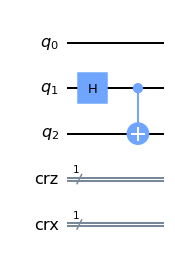

In [4]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

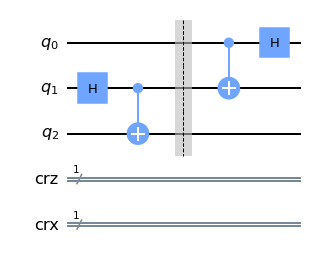

In [6]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

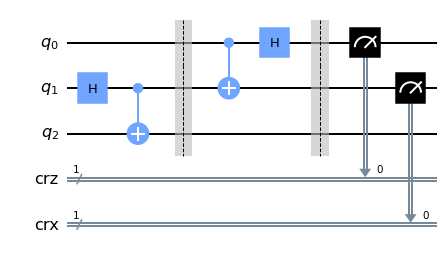

In [8]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

In [9]:
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

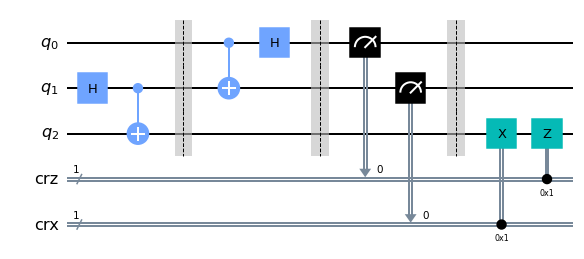

In [10]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

<IPython.core.display.Latex object>

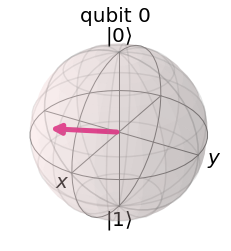

In [11]:
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

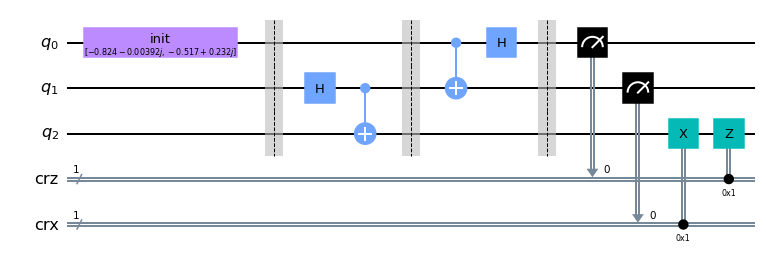

In [13]:
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)
qc.append(init_gate, [0])
qc.barrier()
create_bell_pair(qc, 1, 2)
qc.barrier()
alice_gates(qc, 0, 1)
measure_and_send(qc, 0, 1)
bob_gates(qc, 2, crz, crx)
qc.draw()

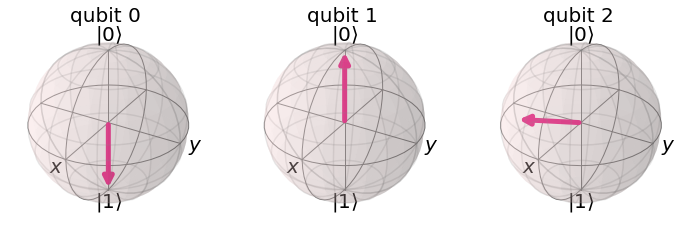

In [14]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()

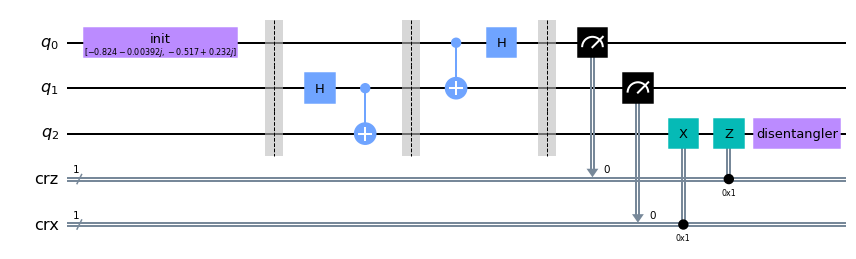

In [16]:
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)
qc.append(init_gate, [0])
qc.barrier()
create_bell_pair(qc, 1, 2)
qc.barrier()
alice_gates(qc, 0, 1)
measure_and_send(qc, 0, 1)
bob_gates(qc, 2, crz, crx)
qc.append(inverse_init_gate, [2])
qc.draw()

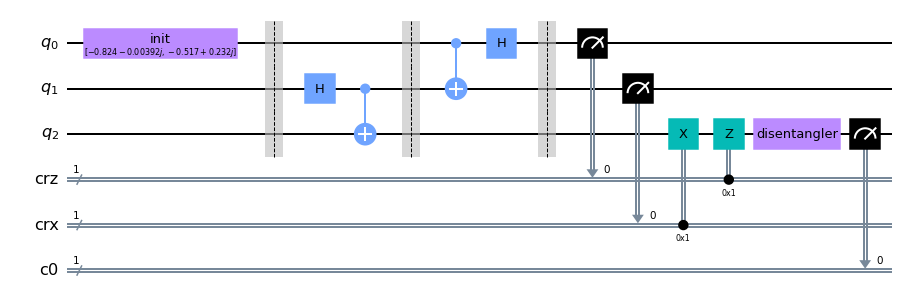

In [17]:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

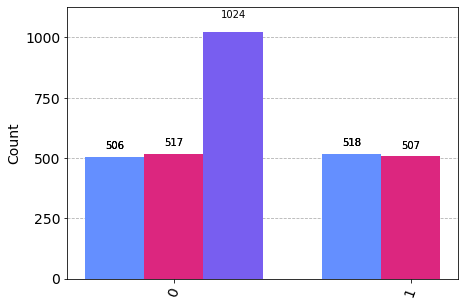

In [18]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

In [19]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

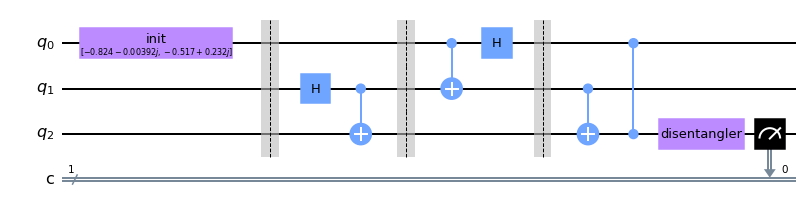

In [20]:
qc = QuantumCircuit(3,1)
qc.append(init_gate, [0])
qc.barrier()
create_bell_pair(qc, 1, 2)
qc.barrier()
alice_gates(qc, 0, 1)
qc.barrier()
new_bob_gates(qc, 0, 1, 2)
qc.append(inverse_init_gate, [2])
qc.measure(2,0)
qc.draw()

In [21]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [22]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  

Job Status: job has successfully run


{'0': 3730, '1': 270}


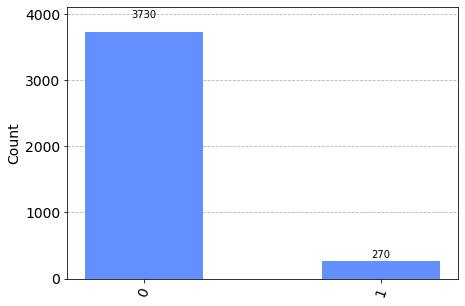

In [23]:
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [24]:
print(f"The experimental error rate : {exp_counts['1']*100/sum(exp_counts.values()):.3f}%")

The experimental error rate : 6.750%


In [25]:
import qiskit.tools.jupyter
%qiskit_version_table